# Prepare dataset - NER filter valid entries
We want to filter the subset of entries for which the alignment of reference tags was successful (i.e. no empty tags were generated) **for all OCR outputs ate the same time.**

We will generate a subset with these entries suitable for stratified train/val/test split for experiment 2 (comparison of NER performance on different OCR outputs).

In [3]:
import os.path

In [4]:
DATASET_PATH = os.path.abspath("../../dataset/supervised")
DATASET_PATH

'/home/joseph/git_github/soduco/paper-ner-bench-das22/dataset/supervised'

In [5]:
ref_path = os.path.join(DATASET_PATH, "10-ref-ocr-ner-json", "all.json")
pero_path = os.path.join(DATASET_PATH, "31-ner_align_pero", "all.json")
tess_path = os.path.join(DATASET_PATH, "32-ner_align_tess", "all.json")
krak_path = os.path.join(DATASET_PATH, "33-ner_align_krak", "all.json")

In [6]:
import json
import io

In [7]:
def merge_filter_ner_gt(ref_path, pero_path, tess_path, csv_path) -> list:  # krak_path,
    # we do not include kraken because the raw performance is too low
    # and this reduces too much the intersection valid entries for NER evaluation
    with open(ref_path) as f:
        reference = json.load(f)
    with open(pero_path) as f:
        pero = json.load(f)
    with open(tess_path) as f:
        tess = json.load(f)
    # with open(krak_path) as f:
    #     krak = json.load(f)

    uid = lambda x: (x["book"], x["page"], x["id"]) 
    ref = { uid(x) : x["ner_xml"] for x in reference}
    pero = { uid(x) : x["ner_xml"] for x in pero if x["has_valid_ner_xml"]}
    tess = { uid(x) : x["ner_xml"] for x in tess if x["has_valid_ner_xml"]}
    # krak = { uid(x) : x["ner_xml"] for x in krak if x["has_valid_ner_xml"]}

    # valid_keys = ref.keys() & pero.keys() & tess.keys() & krak.keys()

    lines_to_write = []
    for key, ner_xml_ref in ref.items():
        ner_xml_pero = pero.get(key)
        ner_xml_tess = tess.get(key)
        # ner_xml_krak = krak.get(key)
        if ner_xml_pero is None or ner_xml_tess is None: # or ner_xml_krak is None:
            # print(" -- Skipping entry")
            continue
        book, _page, _id = key

        # line = '"' + '", "'.join((ner_xml_ref, ner_xml_pero, ner_xml_tess, ner_xml_krak, book)) + '"'
        line = '"' + '", "'.join((ner_xml_ref, ner_xml_pero, ner_xml_tess, book)) + '"'
        lines_to_write.append(line)
    
    print("# filtered entries:", len(lines_to_write))
    all_lines = "\n".join(lines_to_write)
    with io.open(csv_path, "wt", encoding="UTF-8", newline='',
                errors="strict") as file_output:
        # header = '"' + '", "'.join(("ner_xml_ref", "ner_xml_pero", "ner_xml_tess", "ner_xml_krak", "book")) + '"'
        header = '"' + '", "'.join(("ner_xml_ref", "ner_xml_pero", "ner_xml_tess", "book")) + '"'
        file_output.write(header + "\n")
        file_output.write(all_lines)

In [8]:
out_path_csv = os.path.join(DATASET_PATH, "40-ner_aligned_valid_subset", "gold.csv")
ner_filtered = merge_filter_ner_gt(ref_path, pero_path, tess_path, out_path_csv)

# filtered entries: 8341


## More stats

In [12]:
with open(ref_path) as f:
    reference = json.load(f)
with open(pero_path) as f:
    pero = json.load(f)
with open(tess_path) as f:
    tess = json.load(f)
with open(krak_path) as f:
    krak = json.load(f)

uid = lambda x: (x["book"], x["page"], x["id"]) 
ref = { uid(x) : x["ner_xml"] for x in reference if x["valid_box"]}
pero = { uid(x) : x["ner_xml"] for x in pero if x["has_valid_ner_xml"]}
tess = { uid(x) : x["ner_xml"] for x in tess if x["has_valid_ner_xml"]}
krak = { uid(x) : x["ner_xml"] for x in krak if x["has_valid_ner_xml"]}

valid_keys = ref.keys() & pero.keys() & tess.keys() & krak.keys()
print("# ref entries:", len(ref))
print("# pero entries:", len(pero))
print("# tess entries:", len(tess))
print("# krak entries:", len(krak))
print("# pero ∩ tess entries:", len(pero.keys() & tess.keys()))
print("# pero ∩ krak entries:", len(pero.keys() & krak.keys()))
print("# tess ∩ krak entries:", len(tess.keys() & krak.keys()))
print("# pero ∩ tess ∩ krak entries (valid):", len(valid_keys))

NameError: name 'ref_path' is not defined

In [37]:
from text_utils import chop_on_tags, TAG_LIST
import numpy as np

In [41]:
ref_text_len = []
all_tags = []
for xml in ref.values():
    
    texts, tags = chop_on_tags(xml, tag_list=TAG_LIST) 
    ref_text_len.append(len("".join(texts)))
    all_tags.append([t for t in tags if not t.startswith("</")])
print("Mean entry length:", np.mean(ref_text_len))
print("Mean number of tags:", np.mean([len(tags) for tags in all_tags]))
print("# entries used for OCR eval:", len(ref))

Mean entry length: 49.068339988590985
Mean number of tags: 3.9066742726754136
# entries used for OCR eval: 8765


In [39]:
import matplotlib.pyplot as plt

(0.0, 744.7500000000001)

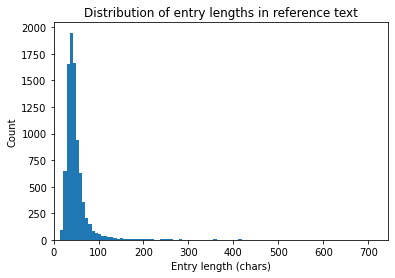

In [40]:
plt.hist(ref_text_len, bins=100)
plt.xlabel("Entry length (chars)")
plt.ylabel("Count")
plt.title("Distribution of entry lengths in reference text")
plt.xlim(left=0)

(0.0, 19.9)

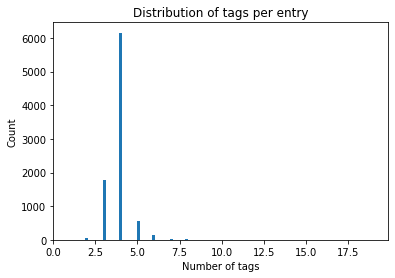

In [47]:
plt.hist([len(tags) for tags in all_tags], bins=100)
plt.xlabel("Number of tags")
plt.ylabel("Count")
plt.title("Distribution of tags per entry")
plt.xlim(left=0)

In [43]:
# Tag stats
from collections import Counter
tag_counter = Counter()
for tags in all_tags:
    tag_counter.update(tags)
tag_counter.most_common()

[('<LOC>', 9709),
 ('<PER>', 8788),
 ('<CARDINAL>', 8747),
 ('<ACT>', 6472),
 ('<TITRE>', 483),
 ('<FT>', 43)]